# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [100]:
! git clone https://github.com/ds4e/linearModels


fatal: destination path 'linearModels' already exists and is not an empty directory.


In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


1. Clean the data and perform some EDA and visualization to get to know the data set.


In [102]:
df = pd.read_csv('./linearModels/data/airbnb_hw.csv')

df.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [103]:
cols = df.columns

for c in cols:
  if df[c].isnull().values.any():
    df = df[df[c].notna()]
    print(c)

df["Neighbourhood"] = df["Neighbourhood "]
df = df.drop(columns=["Neighbourhood "])

Host Since
Property Type
Review Scores Rating (bin)
Zipcode
Beds


In [104]:
df.head()

,Host Id,Host Since,Name,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating,Neighbourhood
4,500,6/26/2008,Trendy Times Square Loft,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0,Manhattan
5,1039,7/25/2008,Big Greenpoint 1BD w/ Skyline View,Apartment,100.0,Entire home/apt,11222.0,1.0,1,4,149,100.0,Brooklyn
6,1783,8/12/2008,Amazing Also,Apartment,100.0,Entire home/apt,10004.0,1.0,1,9,250,100.0,Manhattan
7,2078,8/15/2008,"Colorful, quiet, & near the subway!",Apartment,90.0,Private room,11201.0,1.0,1,80,90,94.0,Brooklyn
8,2339,8/20/2008,East Village Cocoon: 2 Bedroom Flat,Apartment,90.0,Entire home/apt,10009.0,2.0,1,95,270,90.0,Manhattan


In [105]:
df.dtypes


,0
Host Id,int64
Host Since,object
Name,object
Property Type,object
Review Scores Rating (bin),float64
Room Type,object
Zipcode,float64
Beds,float64
Number of Records,int64
Number Of Reviews,int64


In [106]:
for col in ['Price', 'Number of Records', 'Number Of Reviews']:
  df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, invalid parsing will be NaN
  df = df.dropna(subset=[col])  # drop rows with NaN after conversion


df.dtypes


<ipython-input-106-5b311d2b79cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, invalid parsing will be NaN


,0
Host Id,int64
Host Since,object
Name,object
Property Type,object
Review Scores Rating (bin),float64
Room Type,object
Zipcode,float64
Beds,float64
Number of Records,int64
Number Of Reviews,int64


            Host Id  Review Scores Rating (bin)       Zipcode          Beds  \
count  2.195900e+04                21959.000000  21959.000000  21959.000000   
mean   1.105129e+07                   90.725671  10575.806184      1.548568   
std    1.080270e+07                    9.066582    597.782428      1.012670   
min    5.000000e+02                   20.000000   7105.000000      0.000000   
25%    2.242776e+06                   85.000000  10016.000000      1.000000   
50%    6.902857e+06                   90.000000  10044.000000      1.000000   
75%    1.808786e+07                  100.000000  11216.000000      2.000000   
max    4.272660e+07                  100.000000  11694.000000     16.000000   

       Number of Records  Number Of Reviews         Price  \
count            21959.0       21959.000000  21959.000000   
mean                 1.0          16.475067    150.776675   
std                  0.0          24.250080    100.097129   
min                  1.0           1.000000 

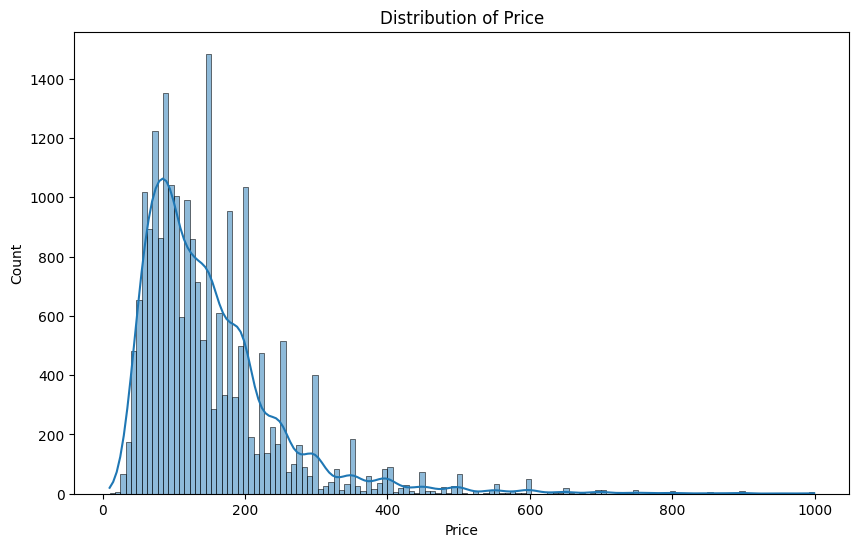

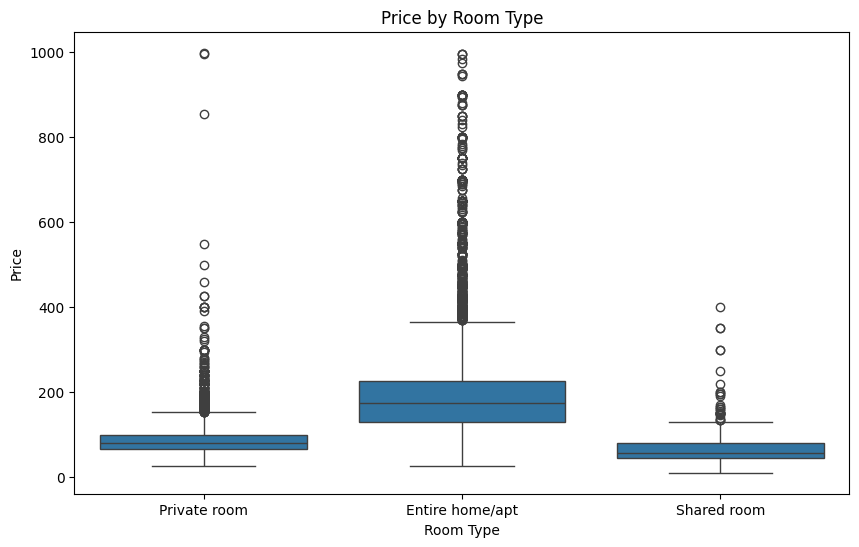

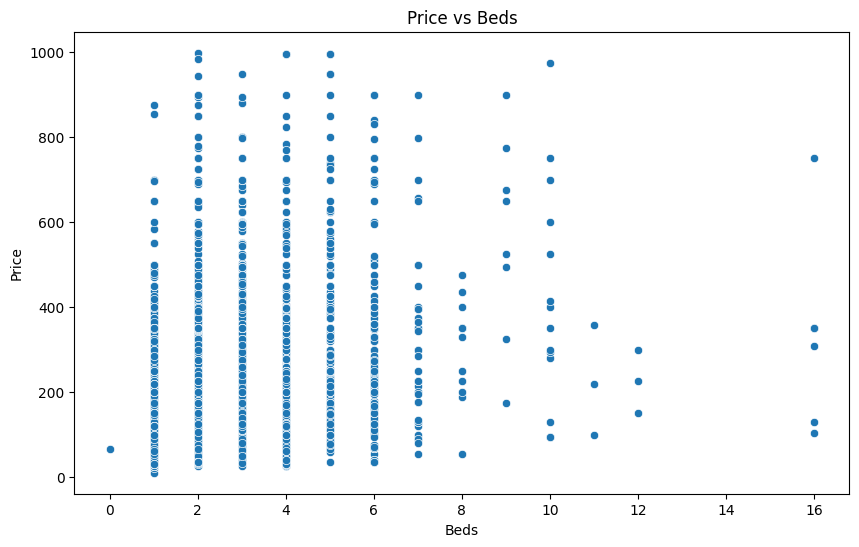

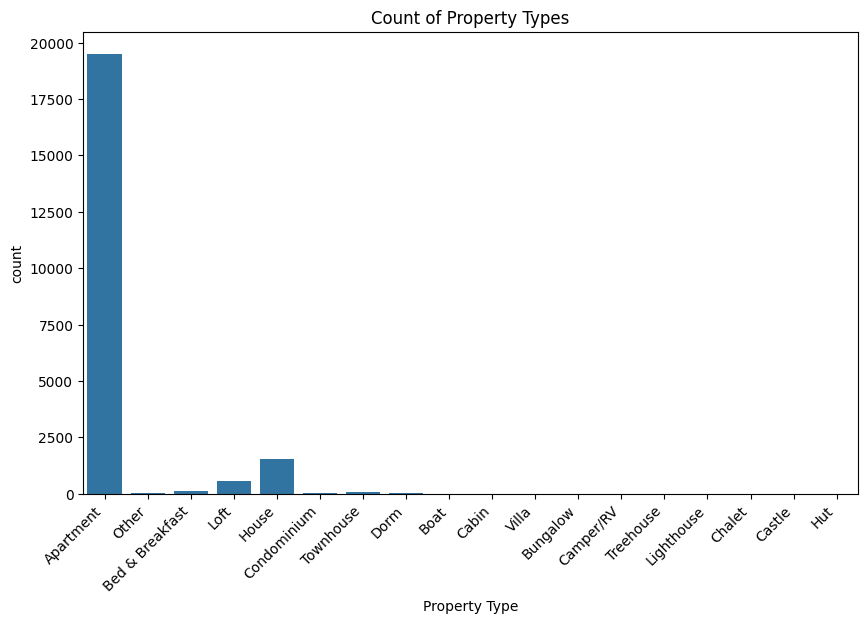

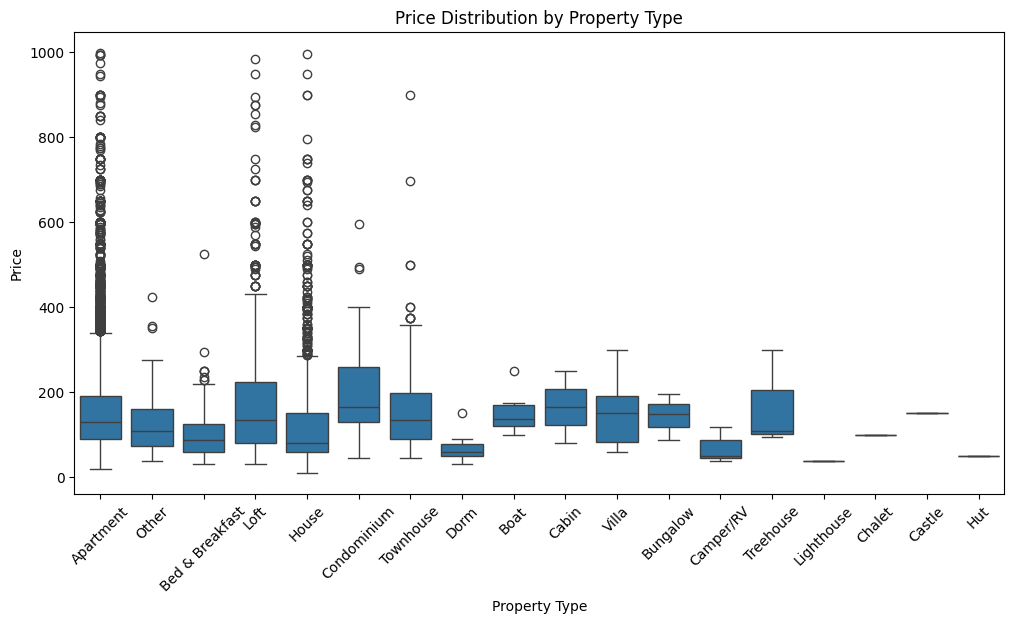

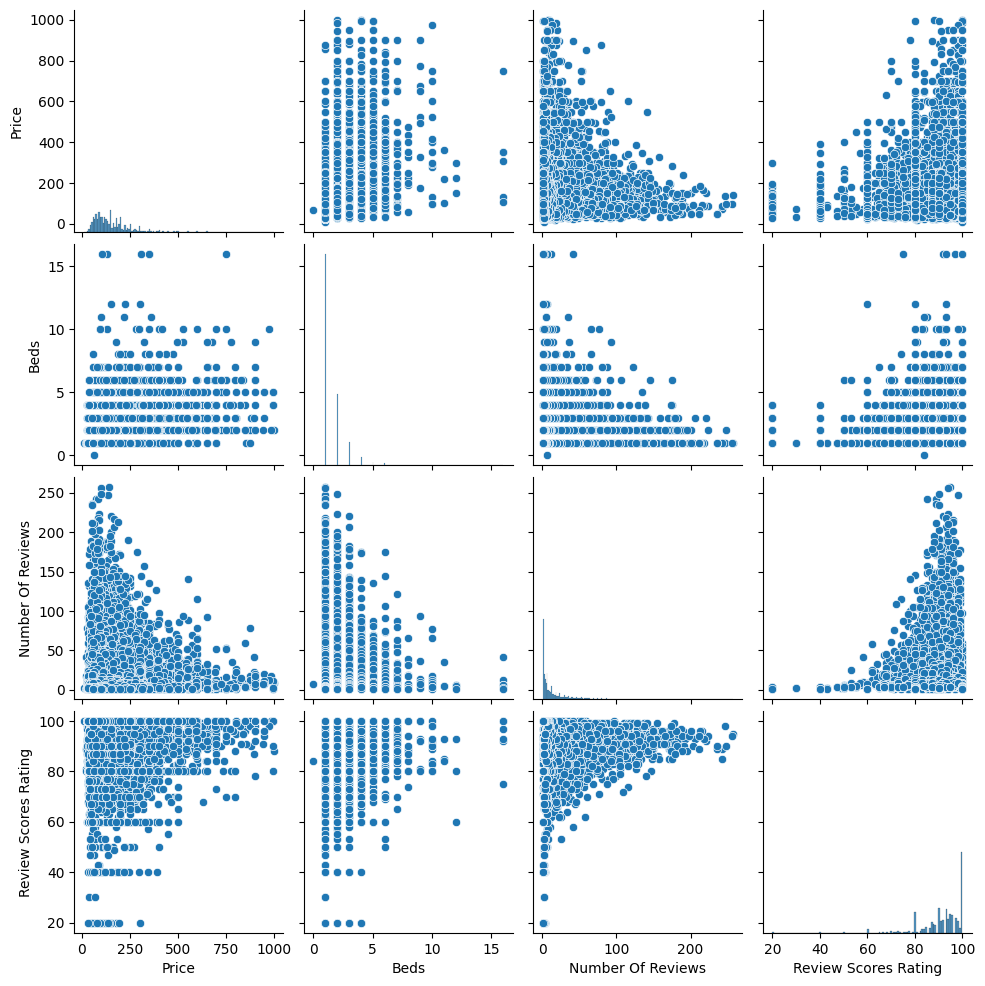

In [107]:
# used help of ai to create EDAs

print(df.describe())


plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True)
plt.title('Distribution of Price')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Room Type', y='Price', data=df)
plt.title('Price by Room Type')
plt.show()


plt.figure(figsize=(10,6))
sns.scatterplot(x='Beds', y='Price', data=df)
plt.title('Price vs Beds')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Property Type', data=df)
plt.title('Count of Property Types')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.show()



# Explore relationships between categorical variables and price
# Example: Boxplot of price by 'Property Type'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Property Type', y='Price', data=df)
plt.title('Price Distribution by Property Type')
plt.xticks(rotation=45)
plt.show()

# Pairplot for numerical variables (select a subset for better visualization)
numerical_cols = ['Price', 'Beds', 'Number Of Reviews', 'Review Scores Rating']
sns.pairplot(df[numerical_cols])
plt.show()


2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.


In [108]:
df.head()

,Host Id,Host Since,Name,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating,Neighbourhood
4,500,6/26/2008,Trendy Times Square Loft,Apartment,95.0,Private room,10036.0,3.0,1,39,549.0,96.0,Manhattan
5,1039,7/25/2008,Big Greenpoint 1BD w/ Skyline View,Apartment,100.0,Entire home/apt,11222.0,1.0,1,4,149.0,100.0,Brooklyn
6,1783,8/12/2008,Amazing Also,Apartment,100.0,Entire home/apt,10004.0,1.0,1,9,250.0,100.0,Manhattan
7,2078,8/15/2008,"Colorful, quiet, & near the subway!",Apartment,90.0,Private room,11201.0,1.0,1,80,90.0,94.0,Brooklyn
8,2339,8/20/2008,East Village Cocoon: 2 Bedroom Flat,Apartment,90.0,Entire home/apt,10009.0,2.0,1,95,270.0,90.0,Manhattan


In [109]:
df.columns

Index(['Host Id', 'Host Since', 'Name', 'Property Type',
       'Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price',
       'Review Scores Rating', 'Neighbourhood'],
      dtype='object')

In [110]:
# making host since numerical

y = df['Price']


df["Host Since Year"] = pd.to_datetime(df["Host Since"]).dt.year

df = df.drop(columns=["Host Since"])



,Host Id,Name,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating,Neighbourhood,Host Since Year
4,500,Trendy Times Square Loft,Apartment,95.0,Private room,10036.0,3.0,1,39,549.0,96.0,Manhattan,2008
5,1039,Big Greenpoint 1BD w/ Skyline View,Apartment,100.0,Entire home/apt,11222.0,1.0,1,4,149.0,100.0,Brooklyn,2008
6,1783,Amazing Also,Apartment,100.0,Entire home/apt,10004.0,1.0,1,9,250.0,100.0,Manhattan,2008
7,2078,"Colorful, quiet, & near the subway!",Apartment,90.0,Private room,11201.0,1.0,1,80,90.0,94.0,Brooklyn,2008
8,2339,East Village Cocoon: 2 Bedroom Flat,Apartment,90.0,Entire home/apt,10009.0,2.0,1,95,270.0,90.0,Manhattan,2008


In [111]:

X_d = pd.get_dummies(df['Neighbourhood'],dtype='int') # Create brand dummies

X_d2 = pd.get_dummies(df['Property Type'],dtype='int') # Create brand dummies


X_d3 = pd.get_dummies(df['Room Type'],dtype='int') # Create brand dummies

X_d4 = pd.get_dummies(df['Zipcode'],dtype='int') # Create brand dummies

X = pd.concat([df.drop(columns=['Neighbourhood', 'Property Type', 'Room Type', 'Zipcode', 'Price', 'Name', 'Host Id']) ,X_d, X_d2], axis=1) # Concatenate engineered features
X.head()



,Review Scores Rating (bin),Beds,Number of Records,Number Of Reviews,Review Scores Rating,Host Since Year,Bronx,Brooklyn,Manhattan,Queens,...,Condominium,Dorm,House,Hut,Lighthouse,Loft,Other,Townhouse,Treehouse,Villa
4,95.0,3.0,1,39,96.0,2008,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,100.0,1.0,1,4,100.0,2008,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,100.0,1.0,1,9,100.0,2008,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,90.0,1.0,1,80,94.0,2008,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,90.0,2.0,1,95,90.0,2008,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


3. Implement an 80/20 train-test split. Put the test data aside.


In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and on the both the training and test sets. Which of your models does the best?


In [118]:
X.columns

Index(['Review Scores Rating (bin)', 'Beds', 'Number of Records',
       'Number Of Reviews', 'Review Scores Rating', 'Host Since Year', 'Bronx',
       'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Apartment',
       'Bed & Breakfast', 'Boat', 'Bungalow', 'Cabin', 'Camper/RV', 'Castle',
       'Chalet', 'Condominium', 'Dorm', 'House', 'Hut', 'Lighthouse', 'Loft',
       'Other', 'Townhouse', 'Treehouse', 'Villa'],
      dtype='object')

In [117]:
import math
from sklearn.metrics import mean_squared_error

data = X.columns


# Initialize and fit the linear regression model
reg = LinearRegression().fit(X_train[data], y_train)

# Make predictions on the test set
a
# Calculate R-squared and RMSE
r_squared = reg.score(X_test[data], y_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared: {r_squared}")
print(f"RMSE: {rmse}")

# Get the coefficient for 'Review Scores Rating'
review_score_coefficient = reg.coef_[0]
print(f"Coefficient for Review Scores Rating: {review_score_coefficient}")


print("Coefficents")
for i, coef in enumerate(reg.coef_):
    print(f"{reg.feature_names_in_[i]}: {coef}")


R-squared: 0.3307836873805181
RMSE: 81.08701535961158
Coefficient for Review Scores Rating: -1.0251220154118421
Coefficents
Review Scores Rating (bin): -1.0251220154118421
Beds: 45.77369459816725
Number of Records: 3.963496197911809e-14
Number Of Reviews: -0.3299048611377331
Review Scores Rating: 2.3821317614302586
Host Since Year: -5.530331522510357
Bronx: -34.448876532151544
Brooklyn: 8.898404450767673
Manhattan: 67.94258332248492
Queens: -9.479618653096868
Staten Island: -32.91249258800412
Apartment: 18.803484103995068
Bed & Breakfast: -17.055931355852305
Boat: 65.16450722025748
Bungalow: 28.767001678121904
Cabin: -59.755259564686554
Camper/RV: -31.43178358233
Castle: 0.5156324672116991
Chalet: 47.38434552665709
Condominium: 58.58097367583947
Dorm: -38.256425827778756
House: 9.276946158227936
Hut: -69.8663201832431
Lighthouse: -96.55407353696138
Loft: 62.19865822048708
Other: 13.320719416782538
Townhouse: 19.900332730679978
Treehouse: -20.783570042496002
Villa: 9.790762895087935


In [121]:
import math
from sklearn.metrics import mean_squared_error

data = ['Review Scores Rating (bin)', 'Beds', 'Bronx',
       'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Apartment',
       'Bed & Breakfast', 'Boat', 'Bungalow', 'Cabin', 'Camper/RV', 'Castle',
       'Chalet', 'Condominium', 'Dorm', 'House', 'Hut', 'Lighthouse', 'Loft',
       'Other', 'Townhouse', 'Treehouse', 'Villa']


# Initialize and fit the linear regression model
reg = LinearRegression().fit(X_train[data], y_train)

# Make predictions on the test set

# Calculate R-squared and RMSE
r_squared = reg.score(X_test[data], y_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared: {r_squared}")
print(f"RMSE: {rmse}")

# Get the coefficient for 'Review Scores Rating'
review_score_coefficient = reg.coef_[0]
print(f"Coefficient for Review Scores Rating: {review_score_coefficient}")


print("Coefficents")
for i, coef in enumerate(reg.coef_):
    print(f"{reg.feature_names_in_[i]}: {coef}")


R-squared: 0.3254200196067977
RMSE: 81.08701535961158
Coefficient for Review Scores Rating: 1.3496909757641558
Coefficents
Review Scores Rating (bin): 1.3496909757641558
Beds: 45.71521798318465
Bronx: -34.38291316119496
Brooklyn: 10.084681574285538
Manhattan: 67.45042825845134
Queens: -11.371852491727363
Staten Island: -31.780344179814524
Apartment: 19.672733611978867
Bed & Breakfast: -19.090292887118643
Boat: 66.15031714117923
Bungalow: 42.821963211577796
Cabin: -46.31455680181095
Camper/RV: -20.98009078294773
Castle: 2.5513240202755605
Chalet: 15.665525583262273
Condominium: 60.3109509589835
Dorm: -32.016555335251596
House: 8.19604336298083
Hut: -83.95176622208278
Lighthouse: -96.79814727874341
Loft: 63.40025672072247
Other: 10.87348958760236
Townhouse: 21.081708507978064
Treehouse: -18.856244046788024
Villa: 7.283340648202647


In [122]:

data = ['Beds',
        'Bronx',
       'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Apartment',
       'Bed & Breakfast', 'Boat', 'Bungalow', 'Cabin', 'Camper/RV', 'Castle',
       'Chalet', 'Condominium', 'Dorm', 'House', 'Hut', 'Lighthouse', 'Loft',
       'Other', 'Townhouse', 'Treehouse', 'Villa']


# Initialize and fit the linear regression model
reg = LinearRegression().fit(X_train[data], y_train)

# Make predictions on the test set

# Calculate R-squared and RMSE
r_squared = reg.score(X_test[data], y_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared: {r_squared}")
print(f"RMSE: {rmse}")

# Get the coefficient for 'Review Scores Rating'
review_score_coefficient = reg.coef_[0]
print(f"Coefficient for Review Scores Rating: {review_score_coefficient}")


print("Coefficents")
for i, coef in enumerate(reg.coef_):
    print(f"{reg.feature_names_in_[i]}: {coef}")


R-squared: 0.31158573072251783
RMSE: 81.08701535961158
Coefficient for Review Scores Rating: 44.77282926827166
Coefficents
Beds: 44.77282926827166
Bronx: -34.76989871743359
Brooklyn: 10.375151930741623
Manhattan: 66.75198289818034
Queens: -11.713300305070801
Staten Island: -30.643935806417105
Apartment: 20.844939116248213
Bed & Breakfast: -19.732365570735695
Boat: 72.92054214864487
Bungalow: 43.47290724012928
Cabin: -64.9665886948096
Camper/RV: -37.82945785135514
Castle: 16.113786638482843
Chalet: 21.490617605922065
Condominium: 63.71445454192918
Dorm: -43.974145625997195
House: 8.057505332507972
Hut: -83.88621336151672
Lighthouse: -83.28221166235006
Loft: 66.52182751675268
Other: 8.444655131118342
Townhouse: 25.872837876013275
Treehouse: -22.048651819490562
Villa: 8.26556143850678


In [123]:

data = ['Review Scores Rating (bin)', 'Beds', 'Number of Records',
       'Number Of Reviews', 'Review Scores Rating',  'Bronx',
       'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Apartment',
       'Bed & Breakfast', 'Boat', 'Bungalow', 'Cabin', 'Camper/RV', 'Castle',
       'Chalet', 'Condominium', 'Dorm', 'House', 'Hut', 'Lighthouse', 'Loft',
       'Other', 'Townhouse', 'Treehouse', 'Villa']


# Initialize and fit the linear regression model
reg = LinearRegression().fit(X_train[data], y_train)

# Make predictions on the test set

# Calculate R-squared and RMSE
r_squared = reg.score(X_test[data], y_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared: {r_squared}")
print(f"RMSE: {rmse}")

# Get the coefficient for 'Review Scores Rating'
review_score_coefficient = reg.coef_[0]
print(f"Coefficient for Review Scores Rating: {review_score_coefficient}")


print("Coefficents")
for i, coef in enumerate(reg.coef_):
    print(f"{reg.feature_names_in_[i]}: {coef}")


R-squared: 0.3272425484287269
RMSE: 81.08701535961158
Coefficient for Review Scores Rating: -1.3455876521112373
Coefficents
Review Scores Rating (bin): -1.3455876521112373
Beds: 45.75253748494757
Number of Records: -3.215774868614574e-11
Number Of Reviews: -0.2328998595324884
Review Scores Rating: 2.7529596965960463
Bronx: -34.98463955950962
Brooklyn: 9.871203248774139
Manhattan: 67.59630843644422
Queens: -11.557909174863456
Staten Island: -30.924962950845718
Apartment: 18.61396710766127
Bed & Breakfast: -17.97805674268294
Boat: 69.43876110803713
Bungalow: 39.66301561612719
Cabin: -45.518427944995054
Camper/RV: -25.062090094843008
Castle: 0.9494287228752395
Chalet: 33.04493764767631
Condominium: 58.51708299749544
Dorm: -34.2196630541259
House: 8.02205698660465
Hut: -85.74109579923402
Lighthouse: -97.61220385533792
Loft: 62.80068160213082
Other: 11.093525055563074
Townhouse: 19.002708945248077
Treehouse: -21.735472422331718
Villa: 6.720844124130755


I would say the first modle with all the variables did the best because it has the highest R^2

5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?

In [131]:
def winsorize(x):
    # Convert from pd to np, if necessary:
    if type(x) == 'pandas.core.series.Series':
        x = x.to_numpy()
    # Compute IQR and 25, 75 quantiles:
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Winsorize x:
    x_winsor = np.copy(x)
    x_winsor[ x < lower_whisker ] = lower_whisker
    x_winsor[ x > upper_whisker ] = upper_whisker
    return(x_winsor)


<ipython-input-146-09d44d18820a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_n['Price X Beds'] = df['Price X Beds']  # Add the interaction term


Initial R^2: 0.0465
Partial R^2 for Price: 0.1158


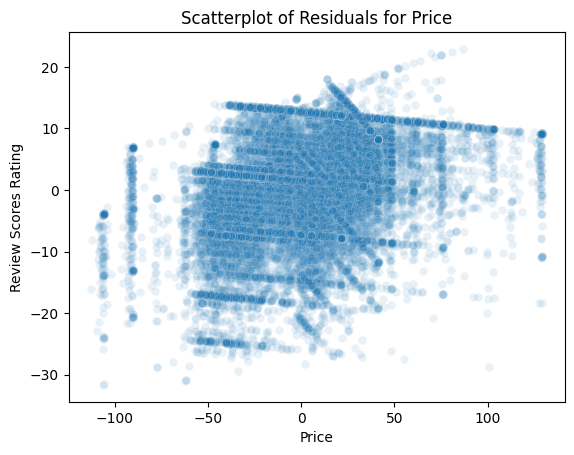

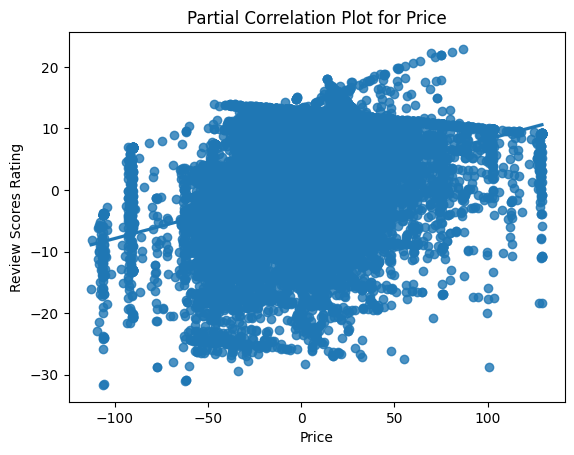

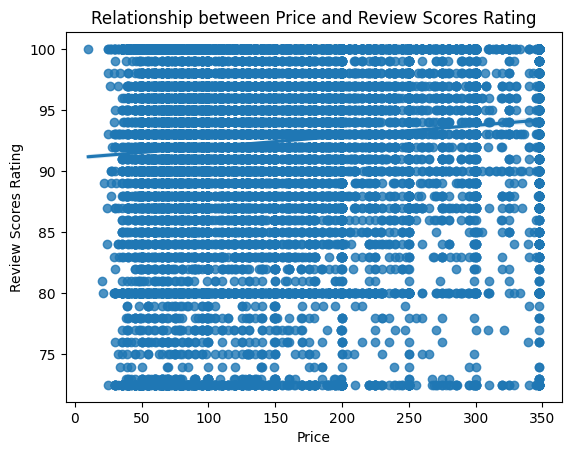

In [146]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

# used help of chat to get this


df.loc[:, ['Price', 'Review Scores Rating', 'Beds', 'Number of Records', 'Number Of Reviews', 'Zipcode']] = \
    df.loc[:, ['Price', 'Review Scores Rating', 'Beds', 'Number of Records', 'Number Of Reviews', 'Zipcode']].apply(winsorize)

df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

df = df.dropna()

y = df['Review Scores Rating']

X_n = df[['Price', 'Beds', 'Number Of Reviews', 'Zipcode']]

df['Price X Beds'] = df['Price'] * df['Beds']
X_n['Price X Beds'] = df['Price X Beds']

X = X_n

reg = LinearRegression(fit_intercept=True).fit(X, y)
print(f'Initial R^2: {reg.score(X, y):.4f}')

var = 'Price'
x_k = X[var]
X_mk = X.drop(var, axis=1)

reg_y = LinearRegression(fit_intercept=False).fit(X_mk, y)
r_y = y - reg_y.predict(X_mk)

reg_k = LinearRegression(fit_intercept=False).fit(X_mk, x_k)
r_x = x_k - reg_k.predict(X_mk)

reg = LinearRegression().fit(r_x.to_numpy().reshape(-1, 1), r_y.to_numpy())
print(f'Partial R^2 for {var}: {reg.score(r_x.to_numpy().reshape(-1, 1), r_y.to_numpy()):.4f}')

sns.scatterplot(y=r_y, x=r_x, alpha=0.1).set(title=f'Scatterplot of Residuals for {var}')
plt.show()

sns.regplot(y=r_y, x=r_x).set(title=f'Partial Correlation Plot for {var}')
plt.show()

sns.regplot(y=y, x=X[var]).set(title=f'Relationship between {var} and Review Scores Rating')
plt.show()


There is a lot of significant non-linearities between the three of these/ With the worst because the Price/Review Scores Rating

6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and on the training and test sets. How does the more complex model your build compare to the simpler ones?


Index(['Price', 'Beds', 'Number Of Reviews', 'Zipcode', 'Price X Beds'], dtype='object')

In [189]:
X = 0
X_d = pd.get_dummies(df['Neighbourhood'],dtype='int') # Create brand dummies

X_d2 = pd.get_dummies(df['Property Type'],dtype='int') # Create brand dummies


X_d3 = pd.get_dummies(df['Room Type'],dtype='int') # Create brand dummies

X_d4 = pd.get_dummies(df['Zipcode'],dtype='int') # Create brand dummies

X = pd.concat([df.drop(columns=['Neighbourhood', 'Property Type', 'Room Type', 'Zipcode', 'Price', 'Name', 'Host Id']) ,X_d, X_d2], axis=1) # Concatenate engineered features

X['Log Review Scores Rating (bin)'] = np.log(df['Review Scores Rating (bin)'])
X['Log Review Scores Rating'] = np.log(df['Review Scores Rating'])
X['Number Of Reviews X Review Scores Rating'] = df['Number Of Reviews'] * df['Review Scores Rating']
X['Number Of Records X Review Scores Rating'] = df['Number of Records'] * df['Review Scores Rating']
X.drop('Review Scores Rating (bin)', axis=1, inplace=True)
X.drop('Review Scores Rating', axis=1, inplace=True)

X.drop('Price X Beds', axis=1, inplace=True)

X.head()
X.columns

Index(['Beds', 'Number of Records', 'Number Of Reviews', 'Host Since Year',
       'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island',
       'Apartment', 'Bed & Breakfast', 'Boat', 'Bungalow', 'Cabin',
       'Camper/RV', 'Castle', 'Chalet', 'Condominium', 'Dorm', 'House', 'Hut',
       'Lighthouse', 'Loft', 'Other', 'Townhouse', 'Treehouse', 'Villa',
       'Log Review Scores Rating (bin)', 'Log Review Scores Rating',
       'Number Of Reviews X Review Scores Rating',
       'Number Of Records X Review Scores Rating'],
      dtype='object')

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [191]:

data = X.columns


# Initialize and fit the linear regression model
reg = LinearRegression().fit(X_train[data], y_train)

# Calculate R-squared and RMSE
r_squared = reg.score(X_test[data], y_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared: {r_squared}")
print(f"RMSE: {rmse}")

# Get the coefficient for 'Review Scores Rating'
review_score_coefficient = reg.coef_[0]
print(f"Coefficient for Review Scores Rating: {review_score_coefficient}")


print("Coefficents")
for i, coef in enumerate(reg.coef_):
    print(f"{reg.feature_names_in_[i]}: {coef}")


R-squared: 1.0
RMSE: 79.1888408512091
Coefficient for Review Scores Rating: -1.4037203526327762e-16
Coefficents
Beds: -1.4037203526327762e-16
Number of Records: 8.7360674250192e-15
Number Of Reviews: -1.7835526612413308e-17
Host Since Year: -1.3419429105502113e-16
Bronx: -5.555614451442782e-15
Brooklyn: -3.7060307997446124e-15
Manhattan: -3.88640602399444e-15
Queens: -4.4812306125394785e-15
Staten Island: 1.8191284981388195e-14
Apartment: -1.4580099512616165e-14
Bed & Breakfast: -9.984843621008123e-15
Boat: -1.2220298004204972e-14
Bungalow: 3.268875267044955e-14
Cabin: 7.121648781933501e-14
Camper/RV: -3.776431804481037e-14
Castle: -3.1526790700097446e-14
Chalet: -3.241289236638855e-14
Condominium: -6.513183828069774e-14
Dorm: 7.429959074009429e-15
House: -1.4716481292186565e-14
Hut: -3.682694216771053e-14
Lighthouse: 2.9189990563894955e-14
Loft: -1.3344334822084053e-14
Other: 3.9734231946764454e-14
Townhouse: -3.628165036460375e-14
Treehouse: 1.1940619588223839e-13
Villa: 4.8121017829

This model theoretically compares favorabley to the others because its R^2 is very high. However, testing on new data would show that it is not that good, but is instead overfitted.


7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?


I learned that more variables and more complexiity does not make a model neccesarily better. When I had the simplier variables in the model, I had something that made sense. However, when I added the more complex variable, I got a model that was overfitted. Overfitting does not help and makes the model less useful. Underfitting is still something to look out for because if I don't have enough data, the correlation will not be high enough.

8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and R squared? We'll cover the Lasso later in detail in class.


My computer is in the shop so, i did not have time